In [5]:
import jax
import jax.numpy as jnp

import matplotlib.pyplot as plt

from ott.geometry import pointcloud
from ott.solvers import linear
import time

In [6]:
# define the two sets of points
rngs = jax.random.split(jax.random.key(0), 42)
size = 100
mu_1 = jax.random.normal(rngs[0], (size, 1))
mu_2 = jax.random.normal(rngs[1], (size, 1)) # sizes can be different
print(mu_1.shape, mu_2.shape)

(100, 1) (100, 1)


In [7]:
geom = pointcloud.PointCloud(mu_1, mu_2, cost_fn=None)
solve_fn = jax.jit(linear.solve)
ot = solve_fn(geom)
print(ot.matrix)

[[1.1375844e-03 4.3346362e-13 6.5655093e-19 ... 3.8484090e-38
  1.8396145e-19 6.1329547e-06]
 [3.1226477e-19 1.8411959e-04 3.8531469e-04 ... 7.5931833e-10
  3.5981959e-04 5.3882726e-08]
 [5.7925801e-05 9.5072520e-25 3.3656640e-33 ... 0.0000000e+00
  5.6297841e-34 5.0963660e-13]
 ...
 [3.1670618e-17 3.0547570e-04 2.2504054e-04 ... 4.4464141e-11
  1.9227529e-04 5.4992410e-07]
 [1.0571874e-20 1.0540439e-04 4.5219762e-04 ... 4.3320743e-09
  4.4889131e-04 8.8461167e-09]
 [4.0637987e-31 1.8609290e-07 7.0336173e-05 ... 1.2975184e-05
  1.0223346e-04 6.4466687e-15]]


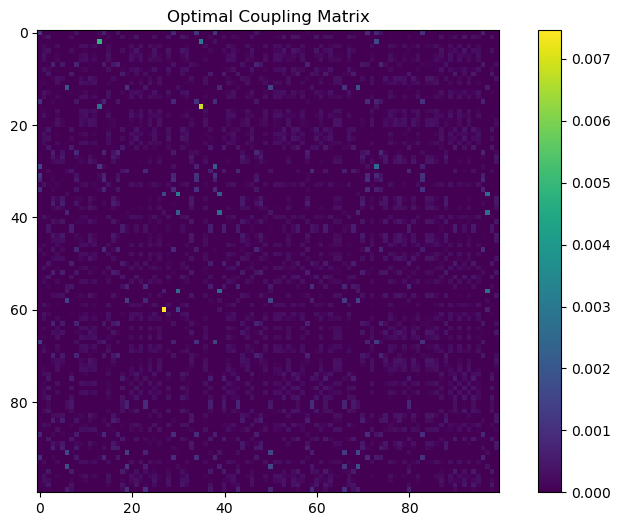

In [8]:
plt.figure(figsize=(10, 6))
plt.imshow(ot.matrix)
plt.colorbar()
plt.title("Optimal Coupling Matrix")
plt.show()

In [16]:
solve_fn = jax.jit(linear.solve)

def random_ott_experiment(n):
    """runs an OT experiment between two collections of n random 1-D points, with random probabilities"""
    rngs = jax.random.split(jax.random.key(4), 42)
    x_1 = jax.random.normal(rngs[0], (n, 1))
    x_2 = jax.random.normal(rngs[1], (n, 1)) # sizes can be different
    mu_1 = jax.random.normal(rngs[2], (n,))
    mu_2 = jax.random.normal(rngs[3], (n,))
    mu_1 = jnp.exp(mu_1) / jnp.sum(jnp.exp(mu_1))
    mu_2 = jnp.exp(mu_2) / jnp.sum(jnp.exp(mu_2))
    geom = pointcloud.PointCloud(x_1, x_2, cost_fn=None, epsilon=1e-4)
    ot = solve_fn(geom, a=mu_1, b=mu_2)
    return ot.matrix, ot.dual_cost, ot.primal_cost

print(mu_1.shape, mu_2.shape)
sizes = [2**k for k in range(11)]
results = []
for size in sizes:
    print(size)
    t1 = time.time()
    coupling, w2_lb, w2_ub = random_ott_experiment(size)
    total_time = time.time() - t1
    results.append([coupling, w2_lb, w2_ub, total_time])

(100, 1) (100, 1)
1
2
4
8
16
32
64
128
256
512
1024


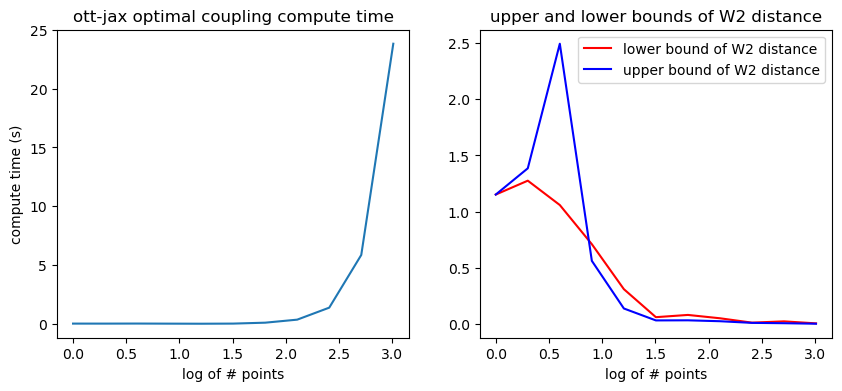

In [17]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
logsizes = [jnp.log10(x) for x in sizes]
ax1.plot(logsizes, [float(row[3]) for row in results])
ax1.set_ylabel('compute time (s)')
ax1.set_xlabel('log of # points')
ax1.set_title('ott-jax optimal coupling compute time')

ax2.plot(logsizes, [float(row[1]) for row in results], color='r', label='lower bound of W2 distance')
ax2.plot(logsizes, [float(row[2]) for row in results], color='b', label='upper bound of W2 distance')
ax2.set_xlabel('log of # points')
ax2.set_title('upper and lower bounds of W2 distance')
ax2.legend()

plt.show()